In [1]:
import logging
import random
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import LazyConfig, instantiate
from detectron2.engine.defaults import create_ddp_model
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
import detectron2.data.transforms as T


import torch
import cv2
from pathlib import Path

import matplotlib.pyplot as plt

import cv2
def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (25,25))
    return plt.imshow(a, **kwargs)

# 모델 학습

In [ ]:
!python ../tools/lazyconfig_train_net_nia_segmentation.py --config-file ../projects/ViTDet/configs/NIA/mask_rcnn_vitdet_b_100ep.py 

# 모델 추론 (Visualization)

In [2]:
base_dir = Path('/home/detectron2')
test_label_dir = base_dir / 'datasets' / 'nia' / 'visible_test_label.json'
test_data_dir = base_dir / 'datasets' / 'nia' / '1.원천데이터'

register_coco_instances('test_data', {}, test_label_dir, test_data_dir)

mydata = DatasetCatalog.get('test_data')
metadata = MetadataCatalog.get('test_data')


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [12]:
sample = random.sample(mydata, 1)[0]
#print(sample['file_name'])
img = cv2.imread(sample['file_name'])
img_ = T.ResizeShortestEdge(short_edge_length=1024, max_size=1024).get_transform(img).apply_image(img)
img_tensor = torch.as_tensor(img_.astype("float32").transpose(2,0,1))

config_file = '/home/detectron2/projects/ViTDet/configs/COCO/mask_rcnn_vitdet_b_100ep.py'
cfg = LazyConfig.load(config_file)
cfg.model.roi_heads.num_classes = 11
cfg.model.roi_heads.box_predictor.test_score_thresh = 0.7
cfg.train.init_checkpoint = '/home/detectron2/output/model_final.pth'
model = instantiate(cfg.model)
model.to('cuda')
model.eval()
DetectionCheckpointer(model).load(cfg.train.init_checkpoint)

with torch.no_grad():
    outputs = model([{'image': img_tensor}])[0]

visualizer = Visualizer(img_[:,:,::-1], instance_mode = ColorMode.IMAGE, metadata=metadata)

instances = outputs['instances'].to('cpu')
visoutput = visualizer.draw_instance_predictions(predictions = instances)
visoutput.save('output.jpg')

# 추론 결과

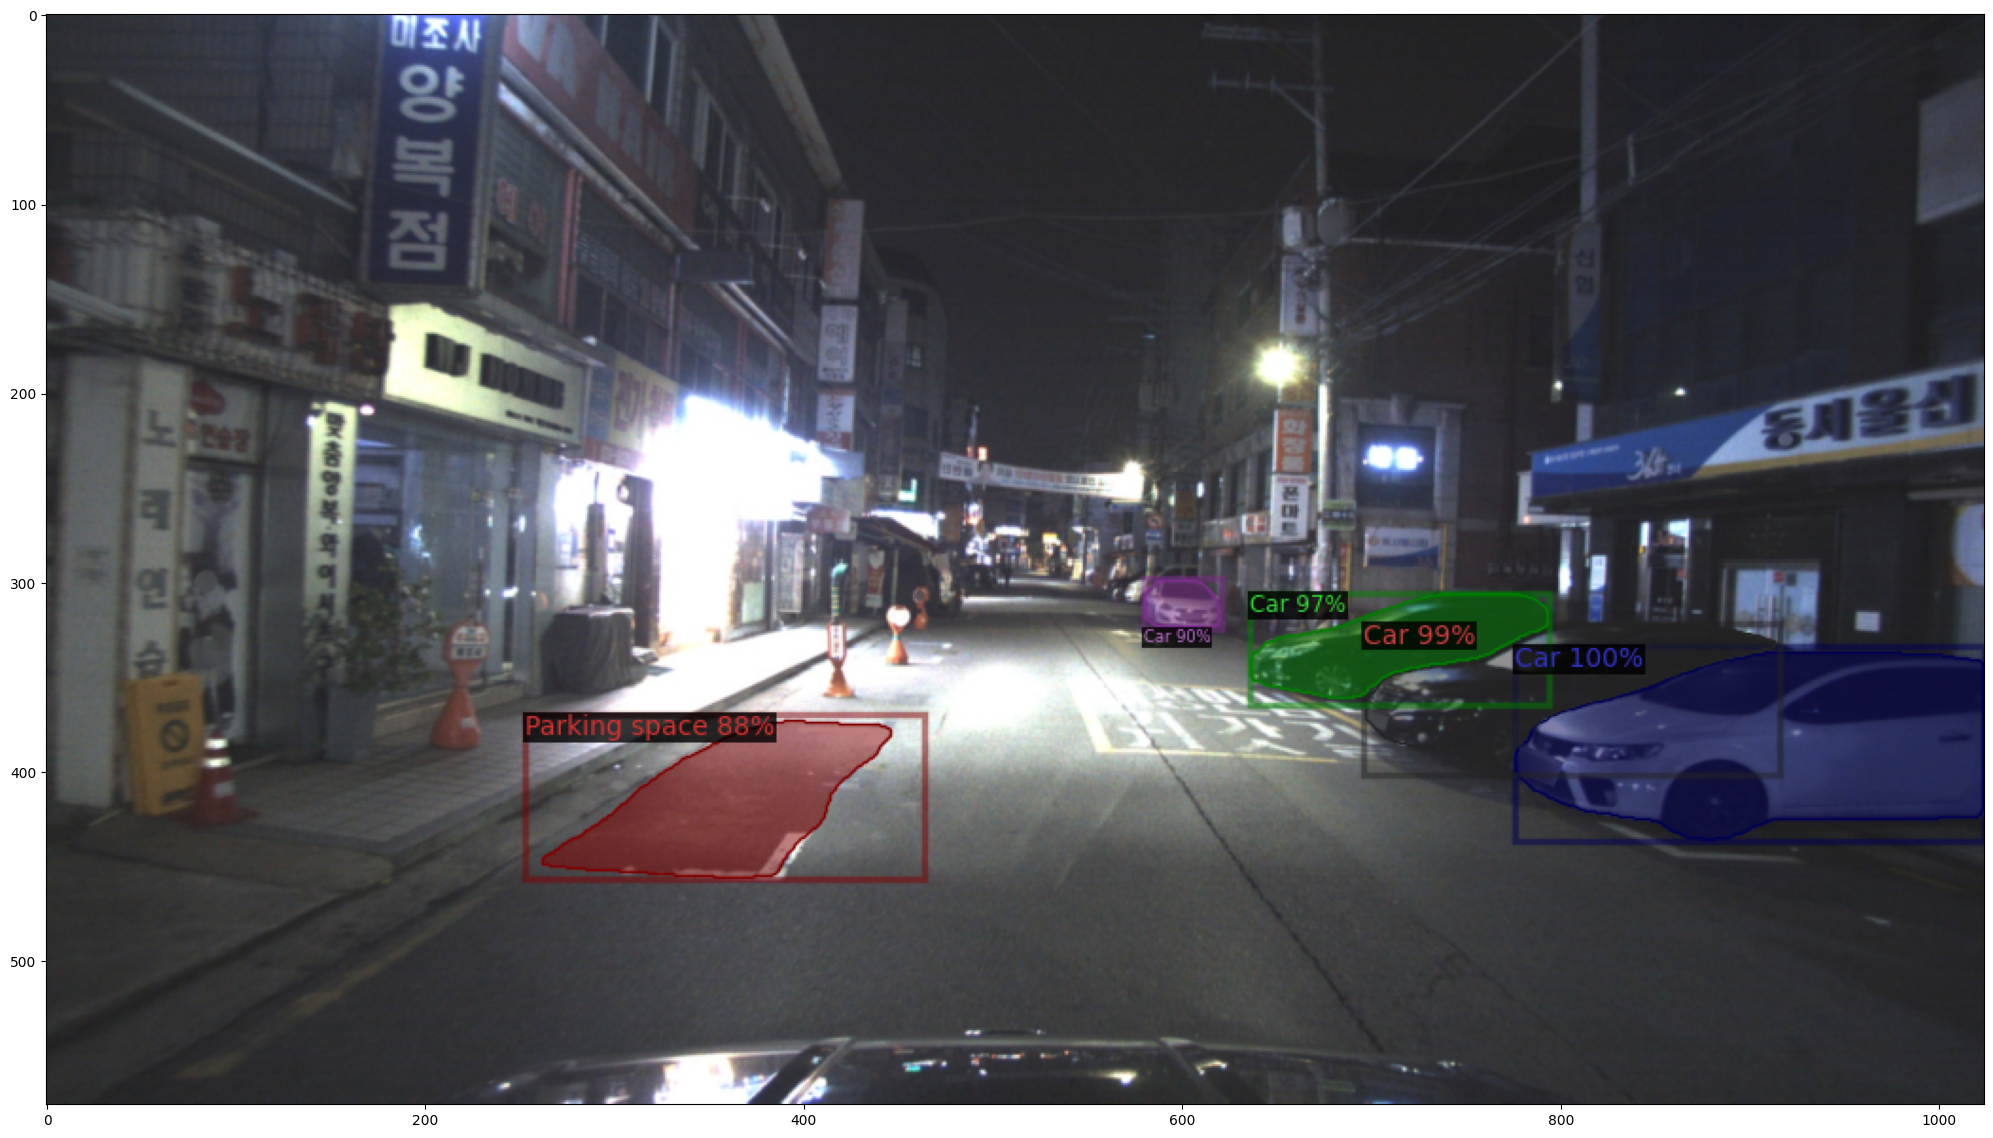

In [13]:
cv2_imshow(visoutput.get_image()[:,:,::-1])

# Ground Truth

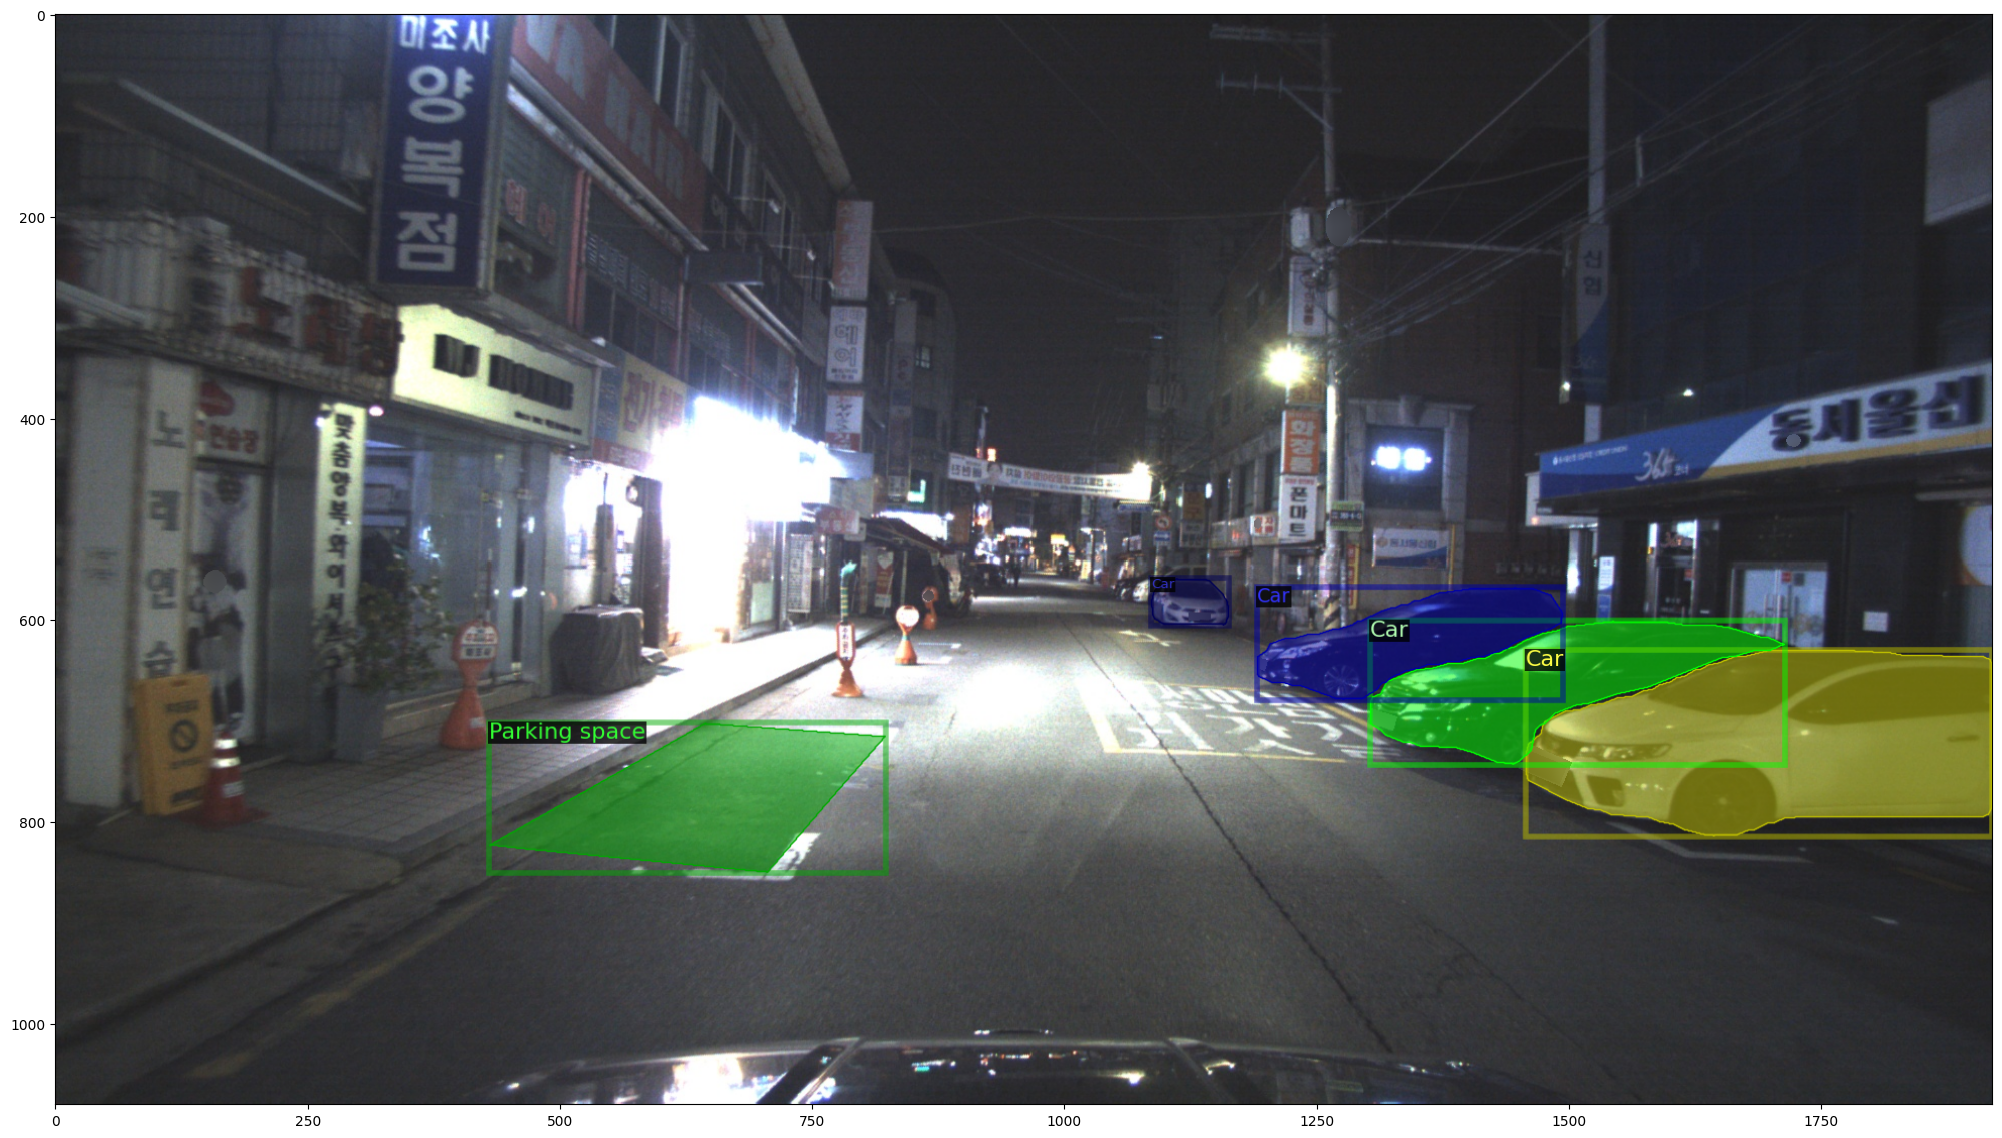

In [14]:
visualizer1 = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer1.draw_dataset_dict(sample)
cv2_imshow(out.get_image()[:, :, ::-1])